# Wikidata evaluation

## Define filepaths

In [1]:
root_dir = '../..'
data_dir = 'data'
corpus_dir = 'corpus'
rank_dir = 'terms'

In [2]:
version = 'v2'

## Load ground truth

In [3]:
import os
import json
import pandas as pd

In [4]:
wikidata_dir = 'cities_wikidata'

In [5]:
datasets_df = []

for filename in os.listdir(os.path.join(root_dir, data_dir, corpus_dir, wikidata_dir)):
    filepath = os.path.join(root_dir, data_dir, corpus_dir, wikidata_dir, filename)
    entry_df = pd.read_excel(filepath, index_col=0)
    datasets_df.append(entry_df)

len(datasets_df)

329

Merge all datasets into a single DataFrame

In [6]:
df = pd.concat(datasets_df, axis=0, ignore_index=True)
df = df[['entity', 'target']].drop_duplicates()
df.head()

,entity,target
0,Q42053,"Isfahan (City in Iran, Isfahan province, cente..."
17,Q1367759,Isfahan Province (Province of Iran)
18,Q25433162,Isfahan (electoral district in Iran)
30,Q21998562,Isfahan (1967 jazz song by Duke Ellington)
45,Q1282082,"Isfahan County (county in Isfahan, Iran)"


## Preprocess ground truth

In [7]:
import re
from nltk import word_tokenize, pos_tag

def filter_terms(text):
    selected_words = []
    tokenized_text = word_tokenize(text)
    for word, tag in pos_tag(tokenized_text):
        if tag.startswith('NN'): # word is a noun (NN)
            word_lowercase = word.lower()
            if word_lowercase not in selected_words and not re.match(r'^q[0-9]+', word_lowercase):
                selected_words.append(word_lowercase)
    
    return ' '.join(selected_words)

In [8]:
'''df['target'] = df['target'].map(lambda x: filter_terms(x))
df['target'].head()'''

"df['target'] = df['target'].map(lambda x: filter_terms(x))\ndf['target'].head()"

In [9]:
gt_dict = pd.Series(df['target'].values,index=df['entity']).to_dict()

In [10]:
del datasets_df
del df

## Load rankings

### LIME on GloVe-based neural network

In [11]:
glove_nn_rank_filename = 'ranking_wikidata_nn_v2.xlsx'
glove_nn_rank_filepath = os.path.join(root_dir, data_dir, rank_dir, glove_nn_rank_filename)

In [12]:
glove_nn_rank_df = pd.read_excel(glove_nn_rank_filepath, index_col=0)
# Replace '_' character with whitespaces
glove_nn_rank_df['term'] = glove_nn_rank_df['term'].map(lambda x: x.replace('_', ' '))
glove_nn_rank_df.head()

,label,term,weight
0,Q1005682,hamburg,3.555413
1,Q1005682,united,2.902431
2,Q1005682,states,2.721304
3,Q1005682,minnesota,2.464700
4,Q1005682,carver,1.904890


In [13]:
glove_nn_rank_df.shape

(3964, 3)

### LIME on DistilBERT

In [14]:
bert_rank_filename = 'ranking_wikidata_bert_v2.xlsx'
bert_rank_filepath = os.path.join(root_dir, data_dir, rank_dir, bert_rank_filename)

In [15]:
bert_rank_df = pd.read_excel(bert_rank_filepath, index_col=0)
# Replace '_' character with whitespaces
bert_rank_df['term'] = bert_rank_df['term'].map(lambda x: x.replace('_', ' '))
bert_rank_df.head()

,label,term,weight
0,Q1005682,hamburg,3.284492
1,Q1005682,minnesota,2.785014
2,Q1005682,carver,2.782782
3,Q1005682,states,1.120218
4,Q1005682,county,0.674296


In [16]:
bert_rank_df.shape

(3003, 3)

### TF-IDF baseline

In [17]:
tfidf_rank_filename = 'ranking_wikidata_baseline_v2.xlsx'
tfidf_rank_filepath = os.path.join(root_dir, data_dir, rank_dir, tfidf_rank_filename)

In [18]:
tfidf_rank_df = pd.read_excel(tfidf_rank_filepath, index_col=0)
tfidf_rank_df['term'] = tfidf_rank_df['term'].map(lambda x: x.replace('_', ' '))
tfidf_rank_df.head()

,label,term
0,Q1754,stockholm
1,Q1754,sthlm
2,Q1754,city
3,Q1754,sweden
4,Q1754,capital


In [19]:
tfidf_rank_df.shape

(895050, 2)

### BART baseline

Load summaries

In [20]:
summaries_filename = 'chunk_summary_wikidata_v2.xlsx'
summaries_filepath = os.path.join(root_dir, data_dir, rank_dir, summaries_filename)

In [21]:
summaries_df = pd.read_excel(summaries_filepath, index_col=0)
summaries_df.head()

,summary
entity,
Q1754,stockholm capital populous_urban_area sweden w...
Q1787199,stockholm_town grant_county south_dakota unite...
Q976601,stockholm village pepin_county wisconsin unite...
Q1484620,stockholm asteroid 10552_stockholm_asteroid as...
Q3447382,stockholm town aroostook_county maine united_s...


Rank terms based on their position

In [22]:
summary_rank_list = []

In [23]:
for idx, row in summaries_df.iterrows():
    summary = row['summary']
    for term in summary.split():
        entry = (idx, term)
        summary_rank_list.append(entry)

In [24]:
summary_rank_df = pd.DataFrame(summary_rank_list, columns=['label', 'term'])
summary_rank_df['term'] = summary_rank_df['term'].map(lambda x: x.replace('_', ' '))
summary_rank_df.head()

,label,term
0,Q1754,stockholm
1,Q1754,capital
2,Q1754,populous urban area
3,Q1754,sweden
4,Q1754,well


In [25]:
summary_rank_df.shape

(3857, 2)

## Compute metrics

In [26]:
src_dir = 'src'

In [27]:
import sys
sys.path.append(os.path.join(root_dir, src_dir))

In [28]:
tfidf_metrics_list = []
summary_metrics_list = []
glove_metrics_list = []
bert_metrics_list = []

In [29]:
grouped_tfidf_df = tfidf_rank_df.groupby('label')
grouped_summary_df = summary_rank_df.groupby('label')
grouped_glove_df = glove_nn_rank_df.groupby('label')
grouped_bert_df = bert_rank_df.groupby('label')

In [30]:
from metrics import compute_metrics

In [31]:
for group_name, group_data in grouped_tfidf_df:
    # compute metrics for the tf-idf baseline
    tfidf_terms = group_data['term'].values
    tfidf_metrics = compute_metrics(group_name, gt_dict, tfidf_terms)
    tfidf_metrics_list.append(tfidf_metrics)

    # compute metrics for the summary-based baseline
    summary_terms = grouped_summary_df.get_group(group_name)['term'].values
    summary_metrics = compute_metrics(group_name, gt_dict, summary_terms)
    summary_metrics_list.append(summary_metrics)

    # compute metrics for the glove-based neural network rankings
    glove_terms = grouped_glove_df.get_group(group_name)['term'].values
    glove_metrics = compute_metrics(group_name, gt_dict, glove_terms)
    glove_metrics_list.append(glove_metrics)

    # compute metrics for the bert-based neural network rankings
    bert_terms = grouped_bert_df.get_group(group_name)['term'].values
    bert_metrics = compute_metrics(group_name, gt_dict, bert_terms)
    bert_metrics_list.append(bert_metrics)

## Plot metrics

In [32]:
from plot import compare_boxplots, compare_lineplots, show_barplot

In [33]:
use_plotly = False

if not use_plotly:
    %matplotlib inline
    %config InlineBackend.figure_format = 'retina'

**Metric #1**: minimum value of `k` s.t `recall[k] > threshold` where `threshold = 0.9`

In [34]:
tfidf_k_recall = [entry['k_recall'] for entry in tfidf_metrics_list if entry['k_recall'] is not None]
summary_k_recall = [entry['k_recall'] for entry in summary_metrics_list if entry['k_recall'] is not None]
glove_k_recall = [entry['k_recall'] for entry in glove_metrics_list if entry['k_recall'] is not None]
bert_k_recall = [entry['k_recall'] for entry in bert_metrics_list if entry['k_recall'] is not None]

In [35]:
print(f'TF-IDF baseline size: {len(tfidf_k_recall)}')
print(f'Summary baseline size: {len(summary_k_recall)}')
print(f'Glove-based network size: {len(glove_k_recall)}')
print(f'BERT-based network size: {len(bert_k_recall)}')

TF-IDF baseline size: 132
Summary baseline size: 77
Glove-based network size: 93
BERT-based network size: 73


In [36]:
plot_labels = ['TF-IDF', 'Summary', 'GloVe', 'BERT']

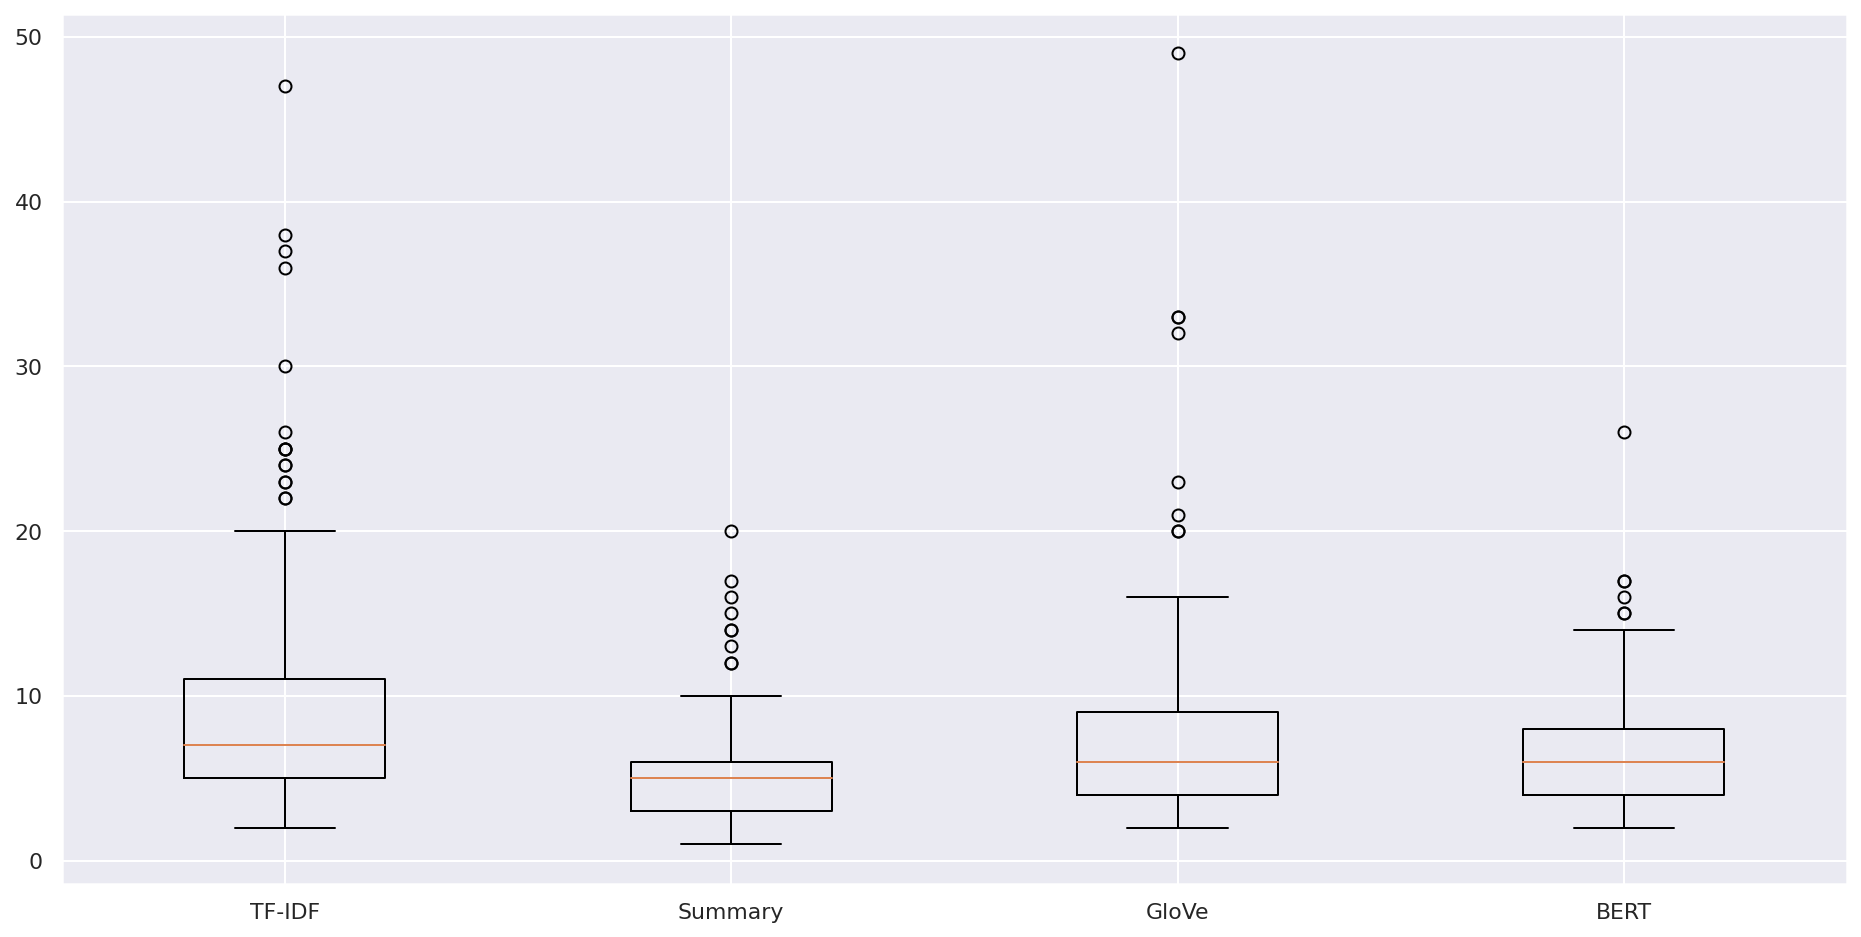

In [37]:
compare_boxplots([tfidf_k_recall, summary_k_recall, glove_k_recall, bert_k_recall], 
                 plot_labels, 
                 use_plotly)

**Metric 2**: maximum F1-score at k

In [38]:
ignore_ids = ['Q1484620', 'Q153721', 'Q383502', 'Q647093', 'Q971268', 'Q1067027', 'Q22713116', 'Q1181264']

In [39]:
min_k = sys.maxsize
min_name = None
for group_name, group_data in grouped_tfidf_df:
    tmp_min = min(group_data.shape[0], 
                  grouped_summary_df.get_group(group_name).shape[0], 
                  grouped_glove_df.get_group(group_name).shape[0], 
                  grouped_bert_df.get_group(group_name).shape[0])
    if tmp_min < min_k and group_name not in ignore_ids:
        min_name = group_name
        min_k = tmp_min
        
min_k += 1 # starts from zero

In [40]:
print(min_name, min_k, sep=' ')

Q3805 4


In [41]:
tfidf_max_f1score = [entry['max_f1score_at_k'][:min_k] for entry in tfidf_metrics_list if entry['entity'] not in ignore_ids]
tfidf_max_f1score_avg = [sum(col)/len(col) for col in zip(*tfidf_max_f1score)]

summary_max_f1score = [entry['max_f1score_at_k'][:min_k] for entry in summary_metrics_list if entry['entity'] not in ignore_ids]
summary_max_f1score_avg = [sum(col)/len(col) for col in zip(*summary_max_f1score)]

glove_max_f1score = [entry['max_f1score_at_k'][:min_k] for entry in glove_metrics_list if entry['entity'] not in ignore_ids]
glove_max_f1score_avg = [sum(col)/len(col) for col in zip(*glove_max_f1score)]

bert_max_f1score = [entry['max_f1score_at_k'][:min_k] for entry in bert_metrics_list if entry['entity'] not in ignore_ids]
bert_max_f1score_avg = [sum(col)/len(col) for col in zip(*bert_max_f1score)]

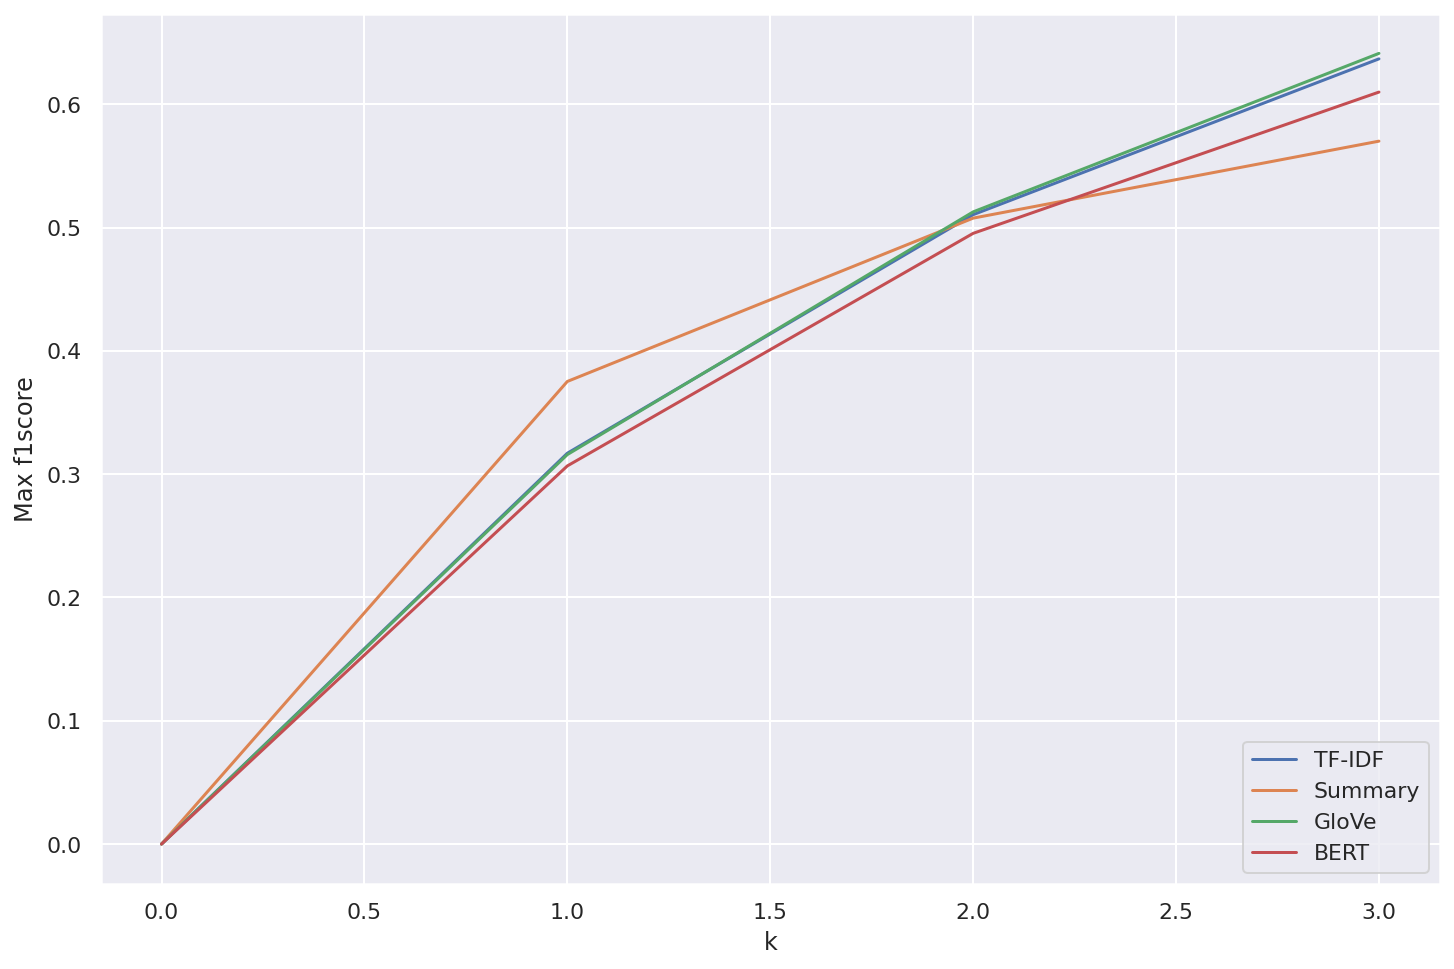

In [42]:
compare_lineplots(list(range(min_k)), 
                  [tfidf_max_f1score_avg, summary_max_f1score_avg, glove_max_f1score_avg, bert_max_f1score_avg],
                  plot_labels,
                  'k', 
                  'Max f1score', 
                  use_plotly)

**Metric 3**: argmax f1-score

In [43]:
tfidf_argmax_f1score = [entry['argmax_f1score'] for entry in tfidf_metrics_list if entry['argmax_f1score'] is not None]
summary_argmax_f1score = [entry['argmax_f1score'] for entry in summary_metrics_list if entry['argmax_f1score'] is not None]
glove_argmax_f1score = [entry['argmax_f1score'] for entry in glove_metrics_list if entry['argmax_f1score'] is not None]
bert_argmax_f1score = [entry['argmax_f1score'] for entry in bert_metrics_list if entry['argmax_f1score'] is not None]

In [44]:
print(f'tfidf_argmax_f1score size: {len(tfidf_argmax_f1score)}')
print(f'summary_argmax_f1score size: {len(summary_argmax_f1score)}')
print(f'glove_argmax_f1score size: {len(glove_argmax_f1score)}')
print(f'bert_argmax_f1score size: {len(bert_argmax_f1score)}')

tfidf_argmax_f1score size: 195
summary_argmax_f1score size: 195
glove_argmax_f1score size: 195
bert_argmax_f1score size: 195


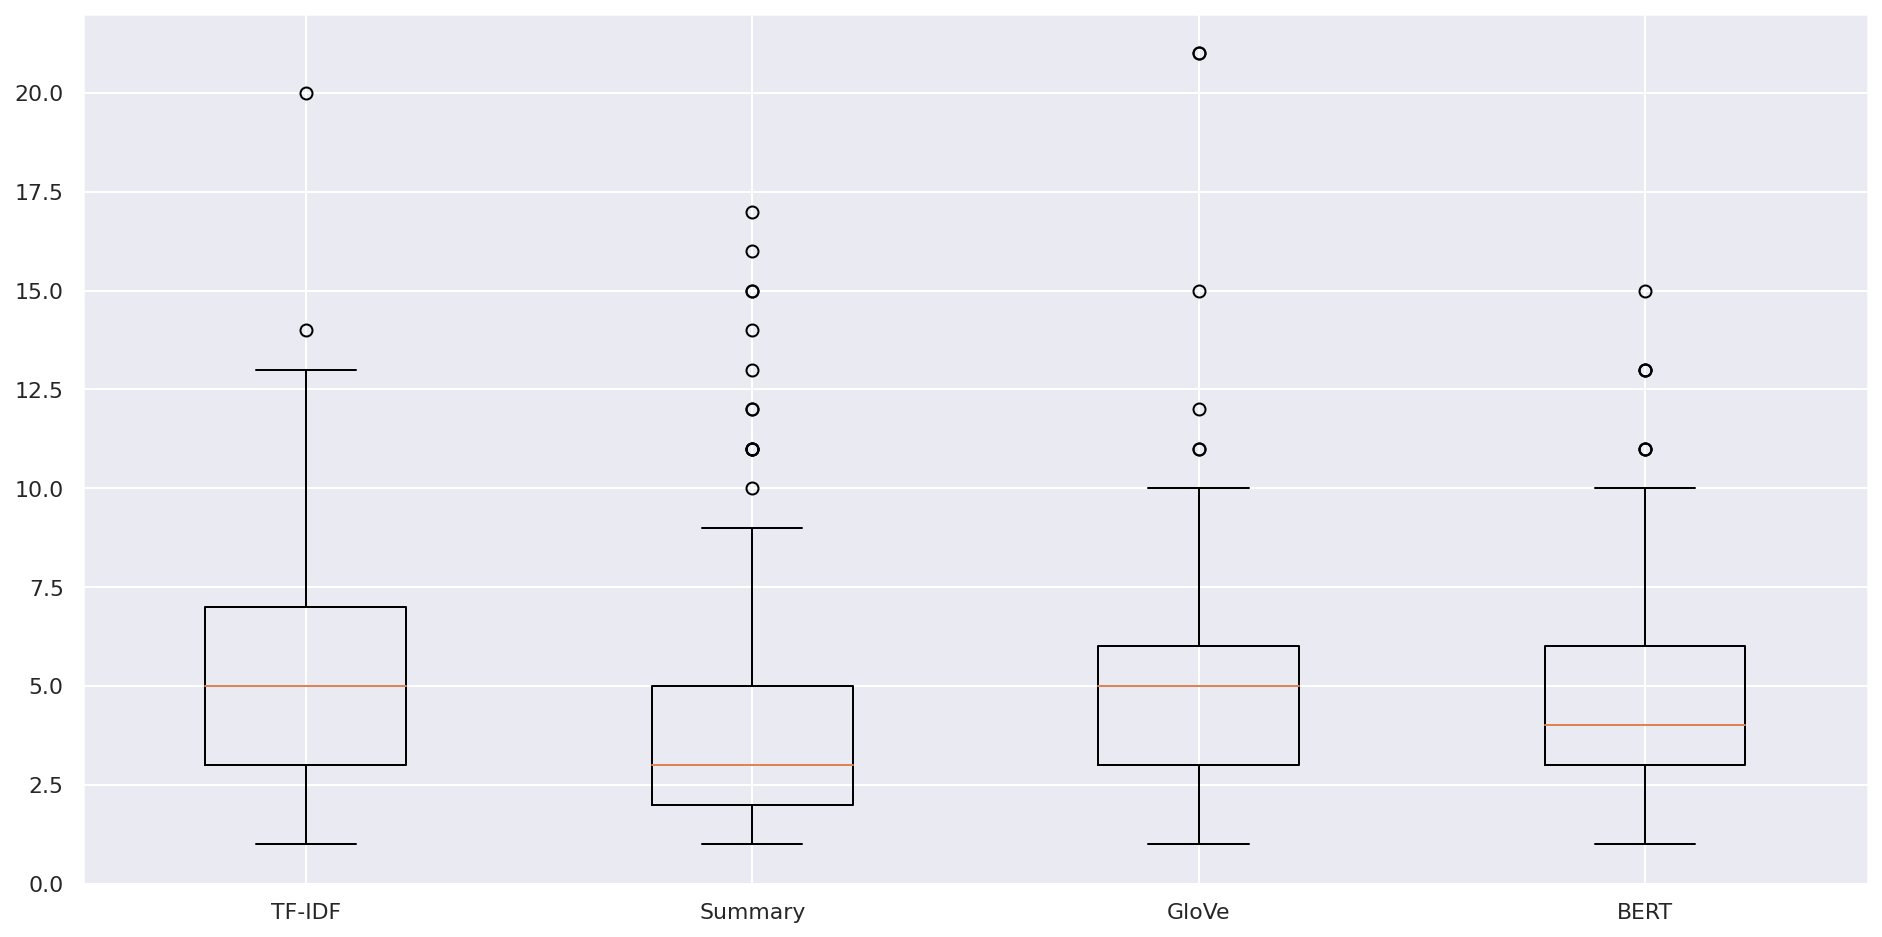

In [45]:
compare_boxplots([tfidf_argmax_f1score, summary_argmax_f1score, glove_argmax_f1score, bert_argmax_f1score],
                 plot_labels, 
                 use_plotly)

**Metric 4**: maximum F2-score at k

In [46]:
tfidf_max_f2score = [entry['max_f2score_at_k'][:min_k] for entry in tfidf_metrics_list if entry['entity'] not in ignore_ids]
tfidf_max_f2score_avg = [sum(col)/len(col) for col in zip(*tfidf_max_f2score)]

summary_max_f2score = [entry['max_f2score_at_k'][:min_k] for entry in summary_metrics_list if entry['entity'] not in ignore_ids]
summary_max_f2score_avg = [sum(col)/len(col) for col in zip(*summary_max_f2score)]

glove_max_f2score = [entry['max_f2score_at_k'][:min_k] for entry in glove_metrics_list if entry['entity'] not in ignore_ids]
glove_max_f2score_avg = [sum(col)/len(col) for col in zip(*glove_max_f2score)]

bert_max_f2score = [entry['max_f2score_at_k'][:min_k] for entry in bert_metrics_list if entry['entity'] not in ignore_ids]
bert_max_f2score_avg = [sum(col)/len(col) for col in zip(*bert_max_f2score)]

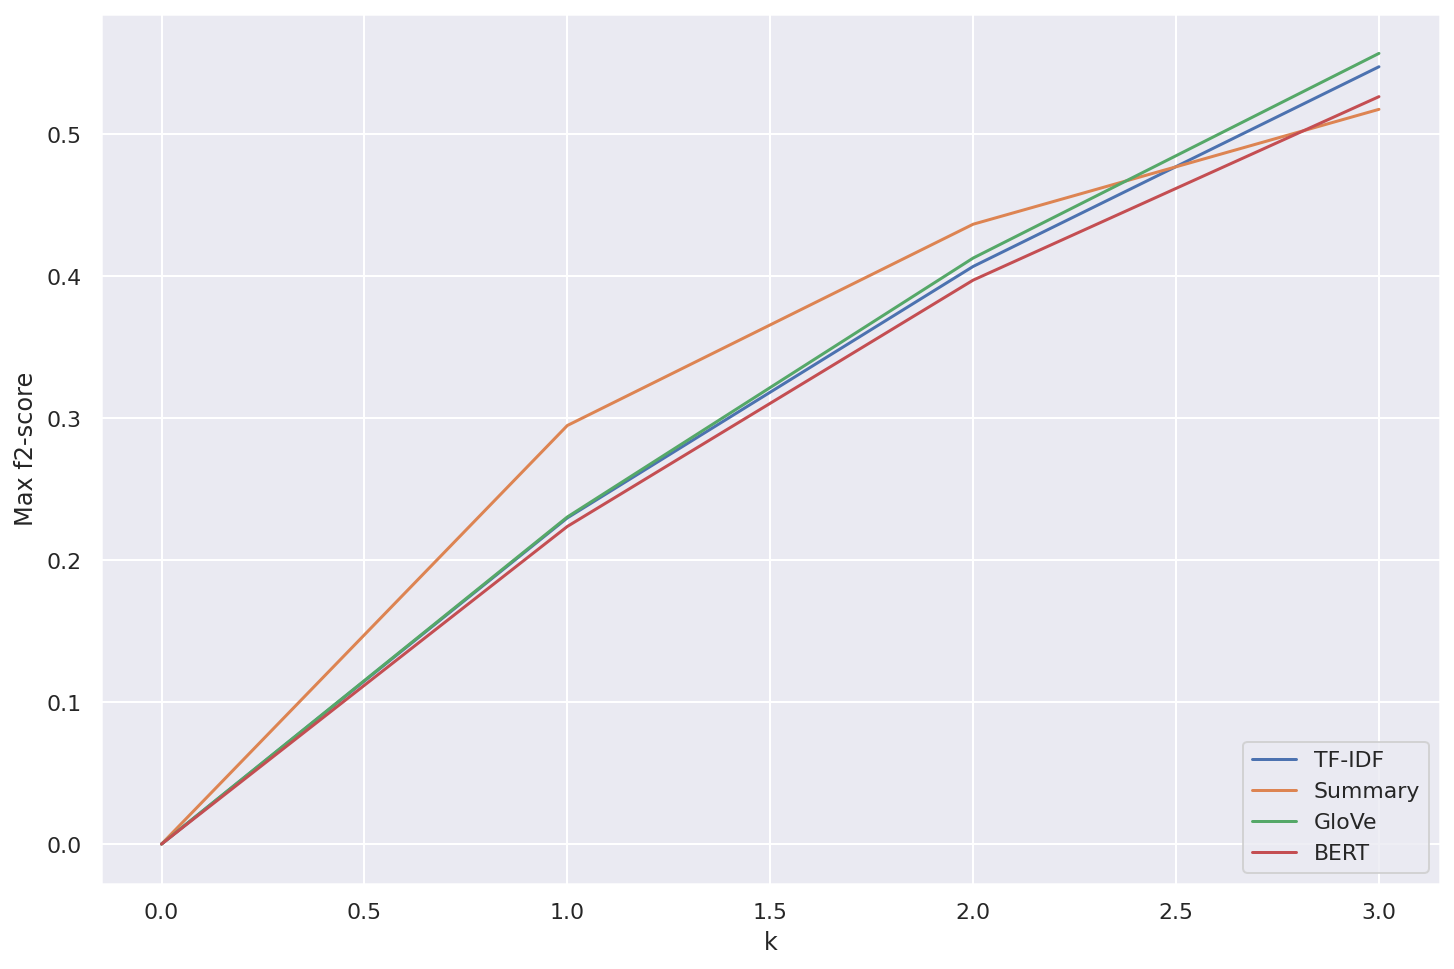

In [47]:
compare_lineplots(list(range(min_k)), 
                  [tfidf_max_f2score_avg, summary_max_f2score_avg, glove_max_f2score_avg, bert_max_f2score_avg],
                  plot_labels,
                  'k', 
                  'Max f2-score', 
                  use_plotly)

**Metric 5**: maximum F0.5-score at k

In [48]:
tfidf_max_f05score = [entry['max_f05score_at_k'][:min_k] for entry in tfidf_metrics_list if entry['entity'] not in ignore_ids]
tfidf_max_f05score_avg = [sum(col)/len(col) for col in zip(*tfidf_max_f05score)]

summary_max_f05score = [entry['max_f05score_at_k'][:min_k] for entry in summary_metrics_list if entry['entity'] not in ignore_ids]
summary_max_f05score_avg = [sum(col)/len(col) for col in zip(*summary_max_f05score)]

glove_max_f05score = [entry['max_f05score_at_k'][:min_k] for entry in glove_metrics_list if entry['entity'] not in ignore_ids]
glove_max_f05score_avg = [sum(col)/len(col) for col in zip(*glove_max_f05score)]

bert_max_f05score = [entry['max_f05score_at_k'][:min_k] for entry in bert_metrics_list if entry['entity'] not in ignore_ids]
bert_max_f05score_avg = [sum(col)/len(col) for col in zip(*bert_max_f05score)]

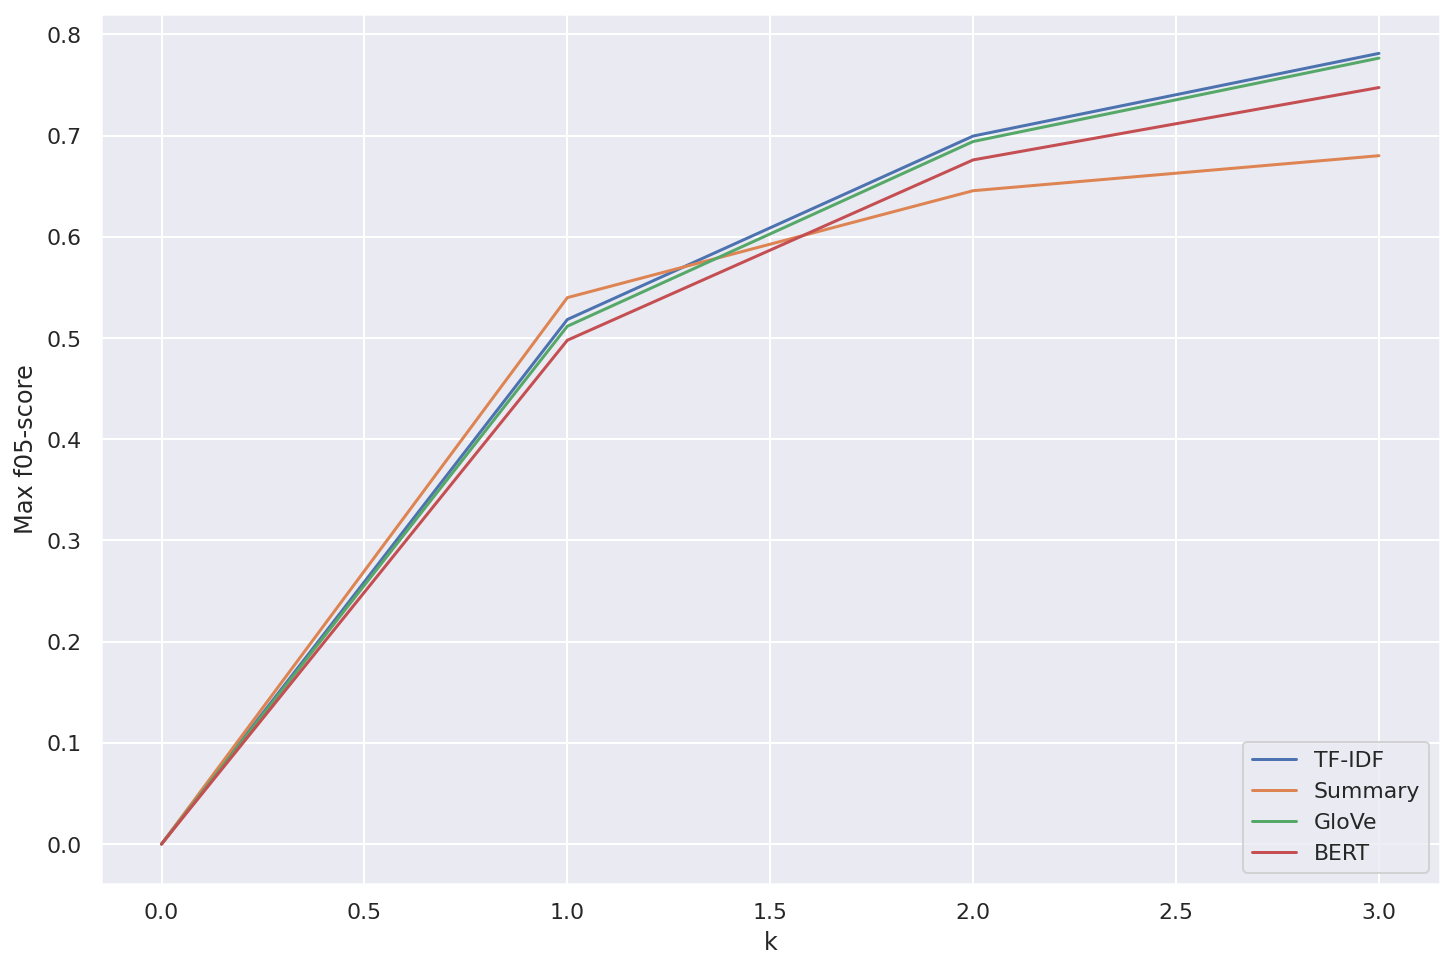

In [49]:
compare_lineplots(list(range(min_k)), 
                  [tfidf_max_f05score_avg, summary_max_f05score_avg, glove_max_f05score_avg, bert_max_f05score_avg],
                  plot_labels,
                  'k', 
                  'Max f05-score', 
                  use_plotly)

**Metric 6**: `max(recall[i])` s.t `precision[i] > threshold` where `threshold = 0.9`

In [50]:
tfidf_max_recall = [entry['max_recall'] for entry in tfidf_metrics_list if entry['max_recall'] is not None]
summary_max_recall = [entry['max_recall'] for entry in summary_metrics_list if entry['max_recall'] is not None]
glove_max_recall = [entry['max_recall'] for entry in glove_metrics_list if entry['max_recall'] is not None]
bert_max_recall = [entry['max_recall'] for entry in bert_metrics_list if entry['max_recall'] is not None]

In [51]:
print(f'tfidf_max_recall size: {len(tfidf_max_recall)}')
print(f'summary_max_recall size: {len(summary_max_recall)}')
print(f'glove_max_recall size: {len(glove_max_recall)}')
print(f'bert_max_recall size: {len(bert_max_recall)}')

tfidf_max_recall size: 185
summary_max_recall size: 159
glove_max_recall size: 181
bert_max_recall size: 178


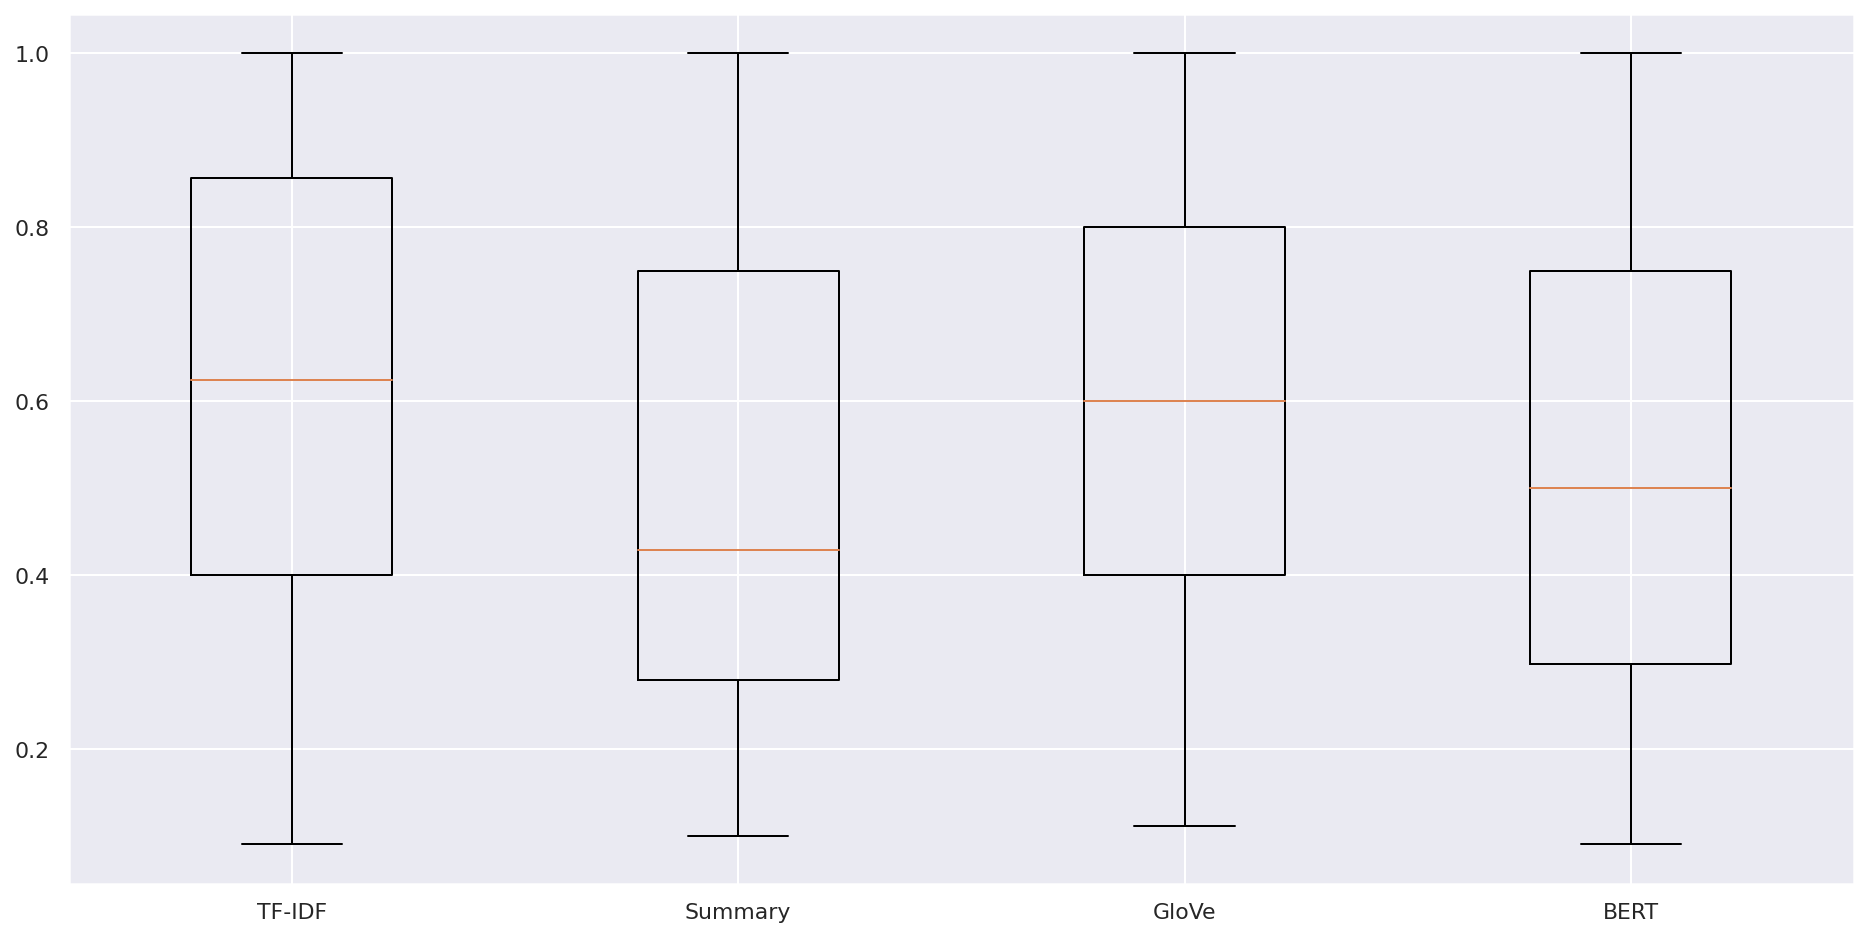

In [52]:
compare_boxplots([tfidf_max_recall, summary_max_recall, glove_max_recall, bert_max_recall], 
                 plot_labels, 
                 use_plotly)

**Metric 7**: `max(precision[i])` s.t `recall[i] > threshold` where `threshold = 0.9`

In [53]:
tfidf_max_precision = [entry['max_precision'] for entry in tfidf_metrics_list if entry['max_precision'] is not None]
summary_max_precision = [entry['max_precision'] for entry in summary_metrics_list if entry['max_precision'] is not None]
glove_max_precision = [entry['max_precision'] for entry in glove_metrics_list if entry['max_precision'] is not None]
bert_max_precision = [entry['max_precision'] for entry in bert_metrics_list if entry['max_precision'] is not None]

In [54]:
print(f'tfidf_max_precision size: {len(tfidf_max_precision)}')
print(f'summary_max_precision size: {len(summary_max_precision)}')
print(f'glove_max_precision size: {len(glove_max_precision)}')
print(f'bert_max_precision size: {len(bert_max_precision)}')

tfidf_max_precision size: 132
summary_max_precision size: 77
glove_max_precision size: 93
bert_max_precision size: 73


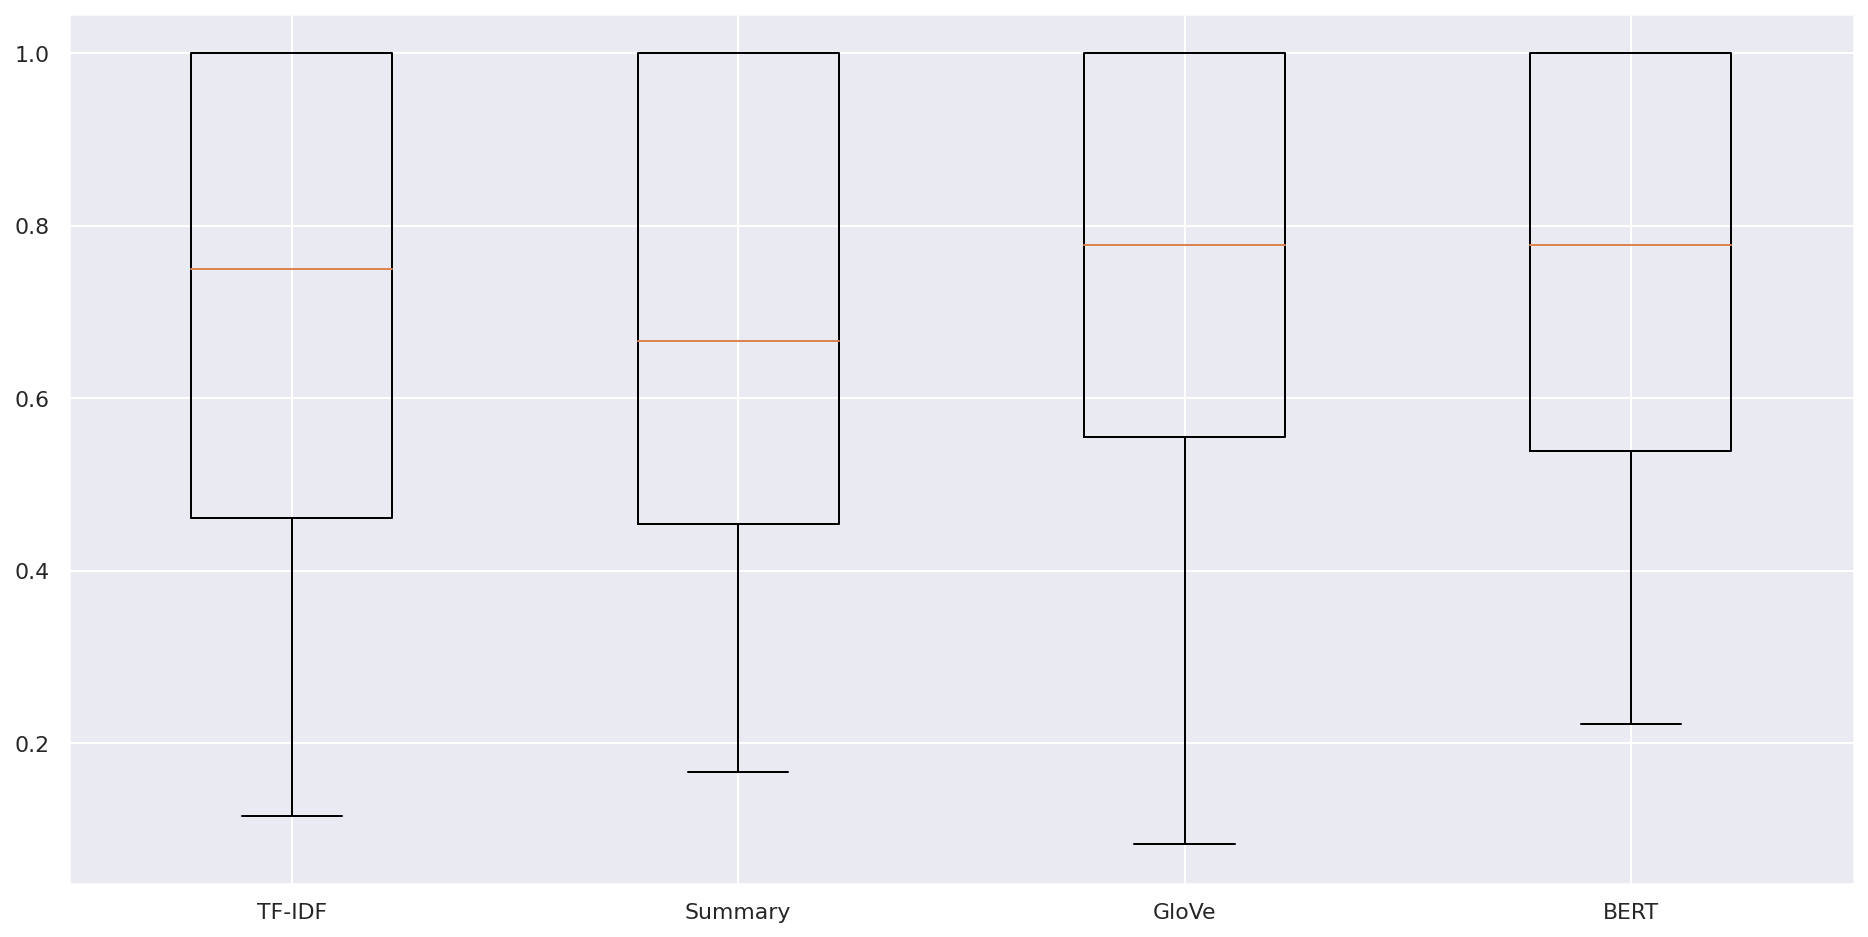

In [55]:
compare_boxplots([tfidf_max_precision, summary_max_precision, glove_max_precision, bert_max_precision], 
                 plot_labels,
                 use_plotly)

**Metric 8**: maximum recall at k

In [56]:
tfidf_max_recall_at_k = [entry['max_recall_at_k'][:min_k] for entry in tfidf_metrics_list if entry['entity'] not in ignore_ids]
tfidf_max_recall_at_k_avg = [sum(col)/len(col) for col in zip(*tfidf_max_recall_at_k)]

summary_max_recall_at_k = [entry['max_recall_at_k'][:min_k] for entry in summary_metrics_list if entry['entity'] not in ignore_ids]
summary_max_recall_at_k_avg = [sum(col)/len(col) for col in zip(*summary_max_recall_at_k)]

glove_max_recall_at_k = [entry['max_recall_at_k'][:min_k] for entry in glove_metrics_list if entry['entity'] not in ignore_ids]
glove_max_recall_at_k_avg = [sum(col)/len(col) for col in zip(*glove_max_recall_at_k)]

bert_max_recall_at_k = [entry['max_recall_at_k'][:min_k] for entry in bert_metrics_list if entry['entity'] not in ignore_ids]
bert_max_recall_at_k_avg = [sum(col)/len(col) for col in zip(*bert_max_recall_at_k)]

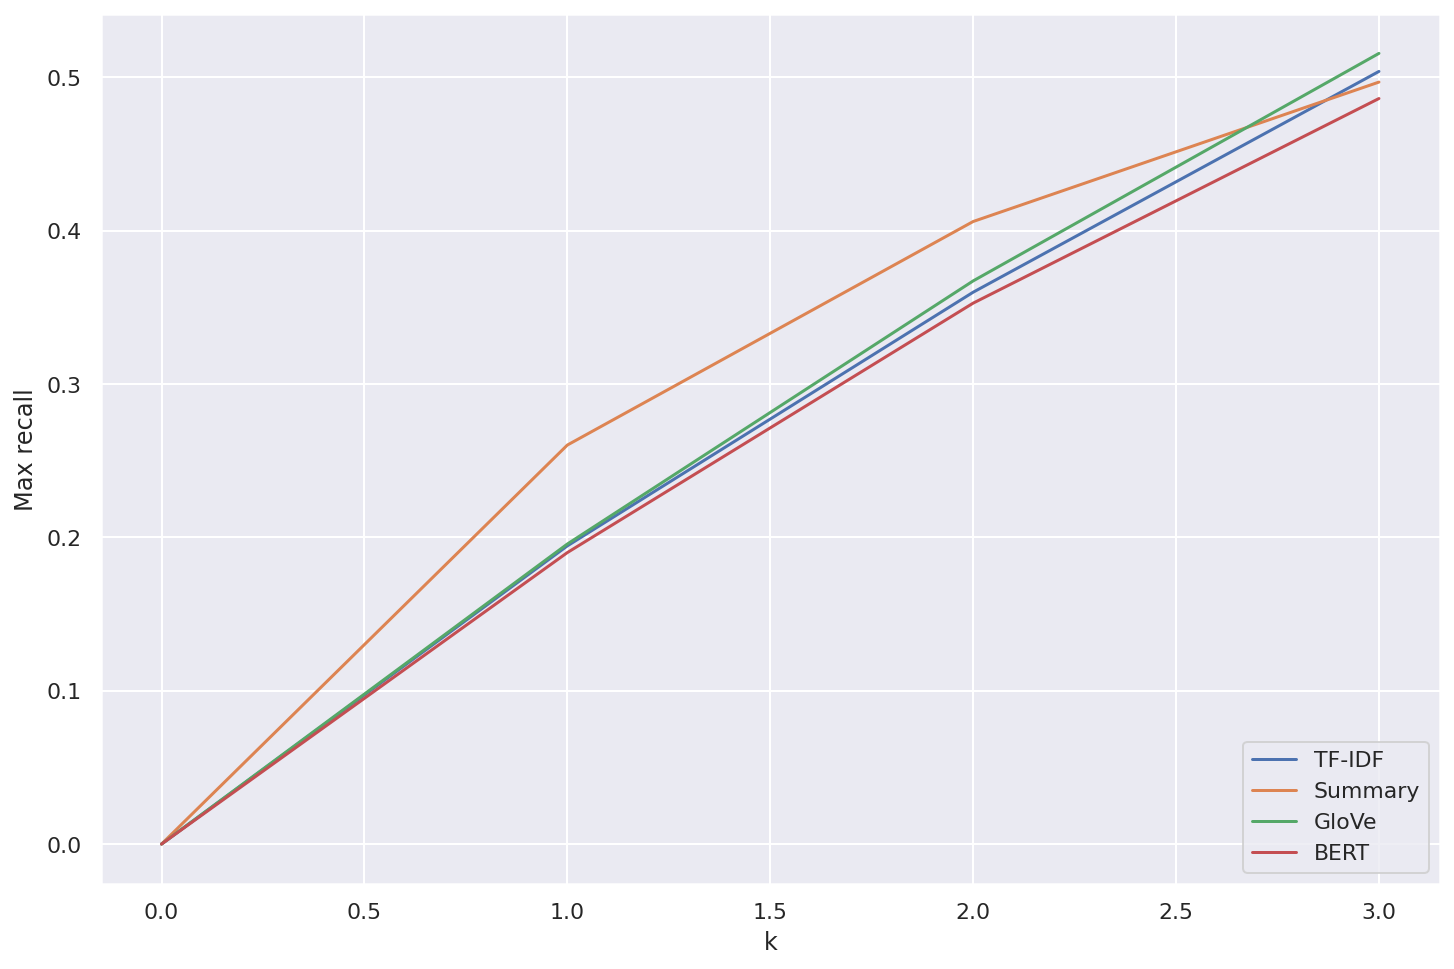

In [57]:
compare_lineplots(list(range(min_k)), 
                  [tfidf_max_recall_at_k_avg, summary_max_recall_at_k_avg, glove_max_recall_at_k_avg, bert_max_recall_at_k_avg],
                  plot_labels,
                  'k', 
                  'Max recall', 
                  use_plotly)

**Metric 9**: maximum precision at k

In [58]:
tfidf_max_precision_at_k = [entry['max_precision_at_k'][:min_k] for entry in tfidf_metrics_list if entry['entity'] not in ignore_ids]
tfidf_max_precision_at_k_avg = [sum(col)/len(col) for col in zip(*tfidf_max_precision_at_k)]

summary_max_precision_at_k = [entry['max_precision_at_k'][:min_k] for entry in summary_metrics_list if entry['entity'] not in ignore_ids]
summary_max_precision_at_k_avg = [sum(col)/len(col) for col in zip(*summary_max_precision_at_k)]

glove_max_precision_at_k = [entry['max_precision_at_k'][:min_k] for entry in glove_metrics_list if entry['entity'] not in ignore_ids]
glove_max_precision_at_k_avg = [sum(col)/len(col) for col in zip(*glove_max_precision_at_k)]

bert_max_precision_at_k = [entry['max_precision_at_k'][:min_k] for entry in bert_metrics_list if entry['entity'] not in ignore_ids]
bert_max_precision_at_k_avg = [sum(col)/len(col) for col in zip(*bert_max_precision_at_k)]

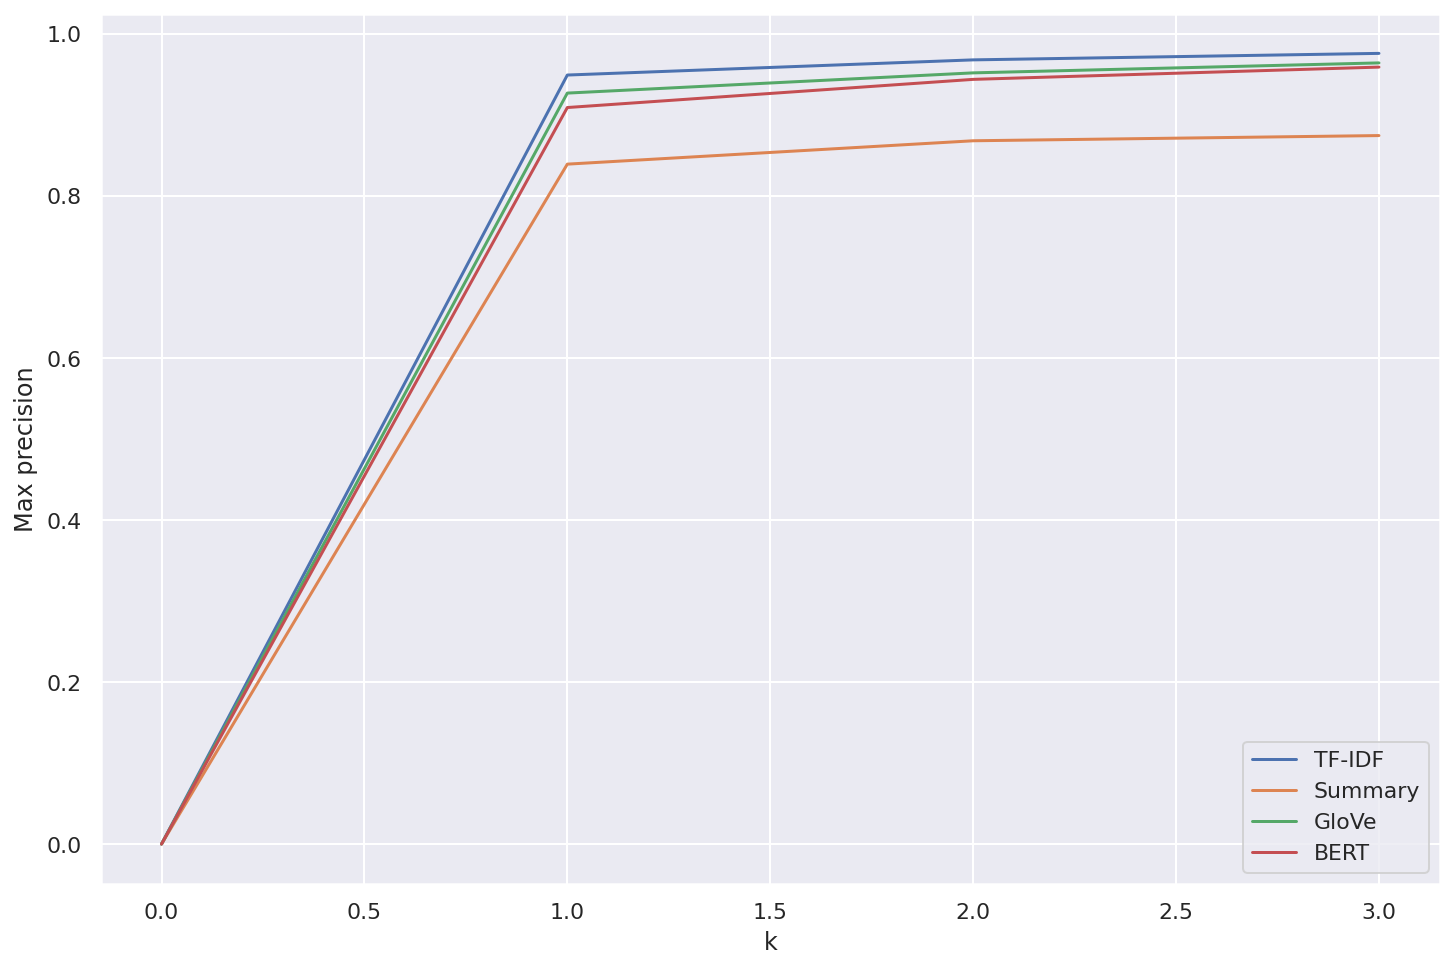

In [59]:
compare_lineplots(list(range(min_k)), 
                  [tfidf_max_precision_at_k_avg, summary_max_precision_at_k_avg, glove_max_precision_at_k_avg, bert_max_precision_at_k_avg],
                  plot_labels,
                  'k', 
                  'Max precision', 
                  use_plotly)

---

## Write top N terms to file

In [60]:
filename = f'top_n_wikidata_{version}.xlsx'
filepath = os.path.join(root_dir, data_dir, rank_dir, filename)

In [61]:
top_n = 100

In [62]:
from training import TrainingCorpus

In [63]:
with pd.ExcelWriter(filepath) as writer:
    for group_name, _ in grouped_tfidf_df:
        tfidf_terms = grouped_tfidf_df.get_group(group_name)['term'][:top_n].values
        summary_terms = grouped_summary_df.get_group(group_name)['term'][:top_n].values
        glove_terms = grouped_glove_df.get_group(group_name)['term'][:top_n].values
        bert_terms = grouped_bert_df.get_group(group_name)['term'][:top_n].values
        target = ' '.join(TrainingCorpus.tokenize(gt_dict[group_name])).lower()

        df = pd.DataFrame({'tfidf_term': pd.Series(tfidf_terms), 
                           'summary_term': pd.Series(summary_terms), 
                           'glove_term': pd.Series(glove_terms), 
                           'bert_term': pd.Series(bert_terms),
                           'target': target})
        df.to_excel(writer,
                    sheet_name=group_name, 
                    index=False)   

---